# BE/Bi 103, Fall 2015: Homework 2 Solutions

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw2_solution.ipynb).*

In [2]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import pyplot for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

### Problem 2.1 (Exploring fish sleep data, 100 pts) 

In [Tutorial 2](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html), we investigated sleeping states of zebrafish larvae.  We had a discussion about what are the best metrics for a sleepful versus waking states based on the one-minute interval activity data we have.  I think we agreed that it is far from obvious how to define a sleepful state.  In this problem, you will work with your group to come up with some good ways to parametrize sleep behavior and estimate the values of these parameters.

Choose three different ways to parametrize sleeping vs. wakeful states.  You can use sleep metrics from the [Prober, et al. paper](http://bebi103.caltech.edu/2014/protected/papers/prober_2006.pdf), ones we discussed in class, or invent your own.  For each of the three ways of parametrizing sleep, provide instructive plots and estimate the values of the parameters.  Compare the relative strengths and weaknesses of the sleep metrics you propose and give a discussion on which parametrization(s) you prefer.

### Problem 2.1 solution

There are many possible approaches to parametrize sleeping versus wakeful states.  Importantly, you should give good justification for your choices and provide meaningful discussion comparing the different methods.

An approach I favor is considering the full distribution of rest bout lengths.   I will apply this approach to the data for the last complete night of the experiment. Let's compute the bout lengths as in [Tutorial 2b](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html).  First, we need our function for computing bout lengths.

In [3]:
def bout_lengths(s, wake_threshold=1e-5, rest=True):
    """
    Given activity series s, returns length of rest bouts / length
    of active_bouts if rest is True/False.
    
    First return value is array of rest bout lengths and second return
    value is array of active bout lengths.
    
    The first/last "bouts" are not included because we don't know where
    they begin/end.  The exception is if the fish is always awake or
    asleep.
    """
    # Get Boolean for activeness
    active = (s > wake_threshold)
    
    # Convert to NumPy array if a Pandas Series
    if type(active) is pd.core.series.Series:
        active = active.values
    
    # Check to make sure there is at least one switch
    if np.all(active):
        if rest:
            return np.array([])
        else:
            return np.array([len(s)])
    elif np.all(~active):
        if rest:
            return np.array([len(s)])
        else:
            return np.array([])
 
    # Use the NumPy diff function to find indices where switches states
    # switches[i] is the index of first time point in state it switched to
    switches = np.where(np.diff(active))[0] + 1
    
    # Compute bout lengths from switches, again using np.diff
    bouts = np.diff(switches)
    
    # Find out if active or rest was first and return bout lengths
    # Not most concise way to do it, but most legible
    if active[0]:
        if rest:
            return bouts[::2]
        else:
            return bouts[1::2]
    else:
        if rest:
            return bouts[1::2]
        else:
            return bouts[::2]

Now, we can load in the data and get our bout length distributions for the last full night.

In [4]:
# Load the DataFrame from Tutorial 2a.
df = pd.read_csv('data/130315_10_minute_intervals.csv')
df_dense = pd.read_csv('data/130315_1_minute_intervals.csv')

# Get indices for third night
inds = (~df_dense.light) & (df_dense.day==2)

# Group the DataFrame
df_gb = df_dense[inds].groupby(('fish', 'genotype'))['activity']

# Compute rest bout lengths
df_rest_bout = df_gb.apply(bout_lengths, rest=True).reset_index()

# Rename activity column
df_rest_bout = df_rest_bout.rename(columns={'activity': 'rest_bout_lengths'})

# Group the rest bout DataFrame by genotype
df_rest_bout_gb = df_rest_bout.groupby('genotype')['rest_bout_lengths']

# Concatenate the arrays of each genotype
wt_bouts = np.concatenate(df_rest_bout_gb.get_group('wt').values)
het_bouts = np.concatenate(df_rest_bout_gb.get_group('het').values)
mut_bouts = np.concatenate(df_rest_bout_gb.get_group('mut').values)

Now we can make histograms of the bout length distributions. Because we have integer steps in bout lengths, we can construct our bins to avoid any binning bias.

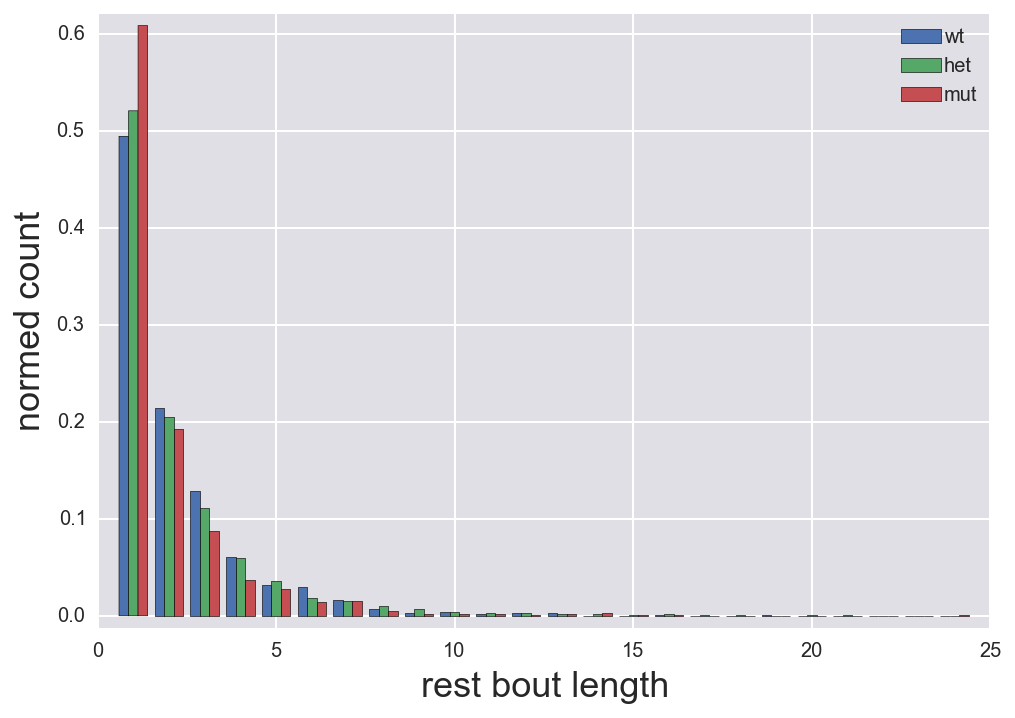

In [5]:
# Find maximal bout length
max_bout = np.concatenate((wt_bouts, het_bouts, mut_bouts)).max()

# Set up bins
bins = np.arange(0.5, max_bout + 1.5)

# Plot the histograms
_ = plt.hist([wt_bouts, het_bouts, mut_bouts], bins=bins, align='mid', 
             normed=True)
plt.margins(y=0.02)

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='upper right')
plt.xlabel('rest bout length')
plt.ylabel('normed count')

We see that the mutant has more one-minute rest bouts and fewer longer ones.  We can also generate a cumulative histogram to show this effect.

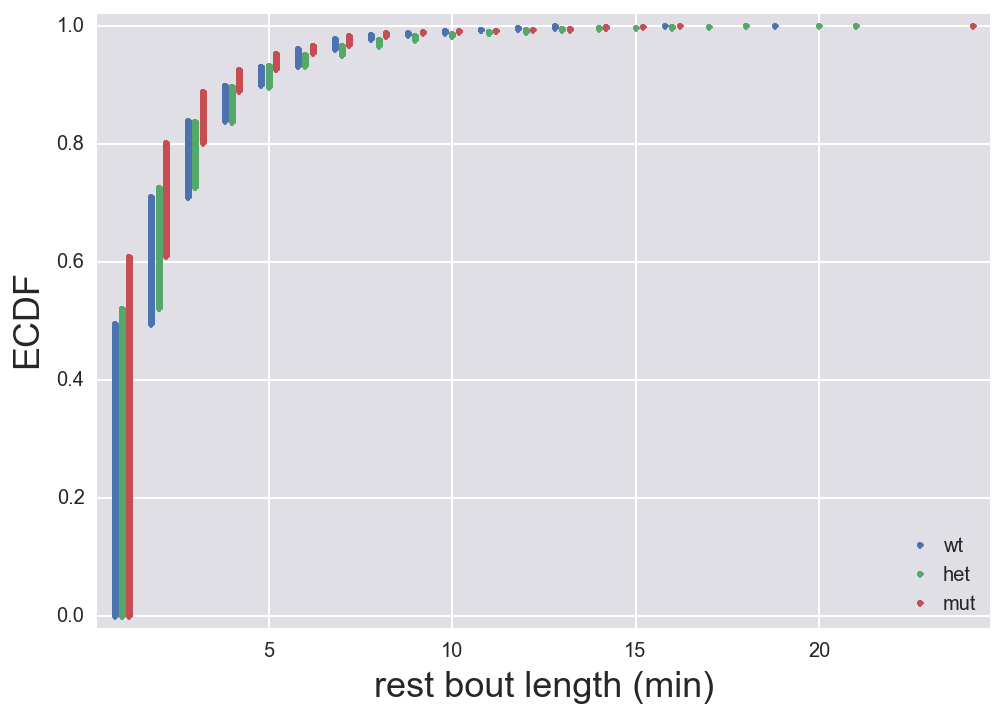

In [6]:
# Generate x-values for each (with staggering)
x_wt = np.sort(wt_bouts) - 0.2
x_het = np.sort(het_bouts)
x_mut = np.sort(mut_bouts) + 0.2

# Generate y-values for each
y_wt = np.arange(1, 1 + len(wt_bouts)) / len(wt_bouts)
y_het = np.arange(1, 1 + len(het_bouts)) / len(het_bouts)
y_mut = np.arange(1, 1 + len(mut_bouts)) / len(mut_bouts)

# Plot cumulative hists
plt.plot(x_wt, y_wt, '.')
plt.plot(x_het, y_het, '.')
plt.plot(x_mut, y_mut, '.')
plt.margins(0.02)

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='lower right')
plt.xlabel('rest bout length (min)')
plt.ylabel('ECDF')

Taking this approach reveals an important modeling approach.  We are trying to define *parameters* to describe fish sleep.  A parametric approach requires a model.  What would be our model for sleep bouts?  One possibility is that exit from a bout of rest is a Poisson process.  Then, we would expect the distribution of sleep bout lengths to be exponentially distributed (as we will learn in the lecture about probability distributions and their meanings).  In this case, the mean of the rest bouts has a physical meaning: it is the characteristic time for exit of a rest bout.  We would then want to see if the rest bouts are indeed exponentially distributed.

A problem with this approach is that the mean sleep bout for mutant fish is about two minutes, as we saw in [Tutorial 2b](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html).  This means that there are most likely many rest bouts that are shorter than one minute.  We would need to have access to higher-frequency data to assess this.  These data are available from the instrument used to do the measurement, and we could perform the analysis to investigate how sleep bouts are distributed.

We might also look at active bouts.  The analysis is analogous.  We start by computing the active bout lengths.

In [9]:
# Compute active bout lengths
df_active_bout = df_gb.apply(bout_lengths, rest=False).reset_index()

# Rename activity column
df_active_bout = df_active_bout.rename(
                    columns={'activity': 'active_bout_lengths'})

# Group the rest bout DataFrame by genotype
df_active_bout_gb = df_active_bout.groupby('genotype')['active_bout_lengths']

# Concatenate the arrays of each genotype
wt_abouts = np.concatenate(df_active_bout_gb.get_group('wt').values)
het_abouts = np.concatenate(df_active_bout_gb.get_group('het').values)
mut_abouts = np.concatenate(df_active_bout_gb.get_group('mut').values)

Now, we again compute and plot the cumulative histograms.

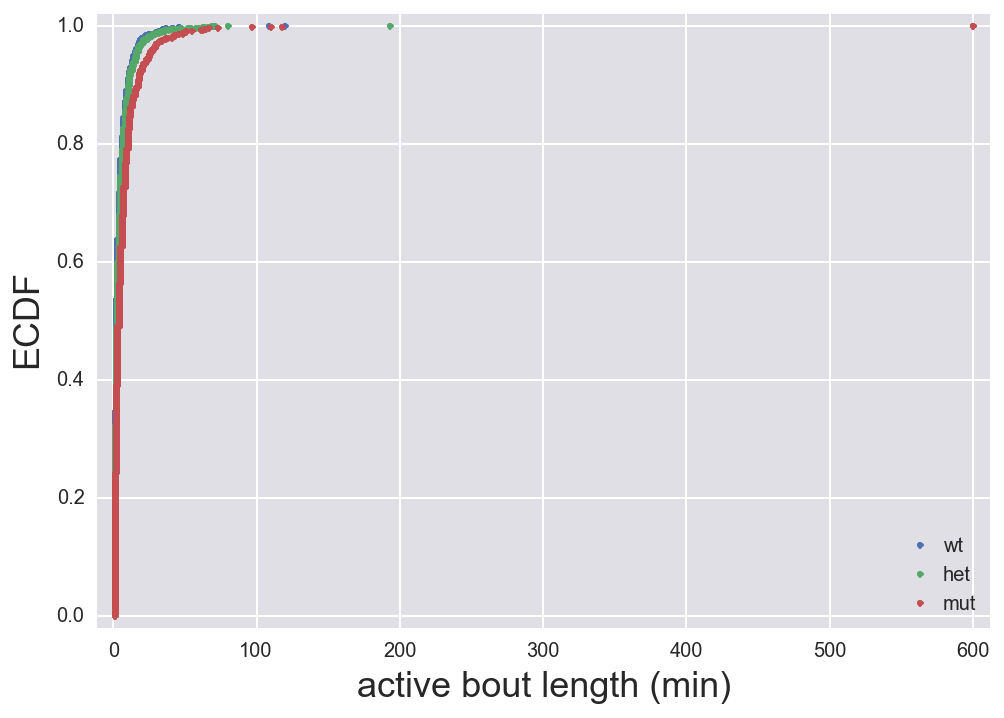

In [10]:
# Generate x-values for each (with staggering)
x_wt = np.sort(wt_abouts)
x_het = np.sort(het_abouts)
x_mut = np.sort(mut_abouts)

# Generate y-values for each
y_wt = np.arange(1, 1 + len(wt_abouts)) / len(wt_abouts)
y_het = np.arange(1, 1 + len(het_abouts)) / len(het_abouts)
y_mut = np.arange(1, 1 + len(mut_abouts)) / len(mut_abouts)

# Plot cumulative hists
plt.plot(x_wt, y_wt, '.')
plt.plot(x_het, y_het, '.')
plt.plot(x_mut, y_mut, '.')
plt.margins(0.02)

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='lower right')
plt.xlabel('active bout length (min)')
plt.ylabel('ECDF')

The presence of very long active bouts (again, likely because we do not sample at low enough frequency to capture short rest bouts that would interrupt these long active bouts), makes the plot harder to read, so we can change the axis limits.

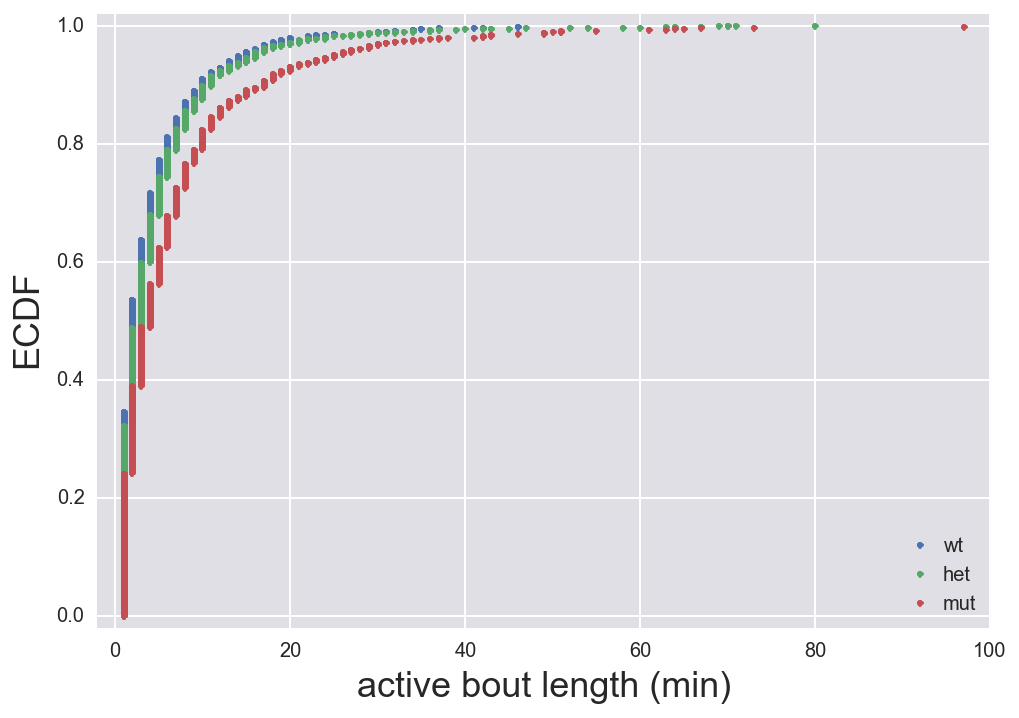

In [11]:
# Plot cumulative hists
plt.plot(x_wt, y_wt, '.')
plt.plot(x_het, y_het, '.')
plt.plot(x_mut, y_mut, '.')
plt.margins(y=0.02)
plt.xlim((-2, 100))

# Labels and legend
plt.legend(['wt', 'het', 'mut'], loc='lower right')
plt.xlabel('active bout length (min)')
plt.ylabel('ECDF')

Here, the presence of longer active bouts is pronounced in the homozygous mutants.  Heterozygous mutants also show very slightly longer active bouts than wild type, and a propensity for having quite long active bouts (again, possibly an artifact of the low-frequency sampling).

<br />
<br />

### Problem 2.2 (Mean of mean rest bout length, 30 pts extra credit)

*This problem will be better understood after lecture on Wednesday, October 7.*

Much of this problem involves fairly lengthy theoretical calculations.  If you want to scan your (legible!) hand-written notes and include them in your Jupyter notebook submission, you may do so.  Make sure they render well in the notebook and are legible.  To include an image called `handwritten.png` using Markdown, do the following:

    ![alt text](handwritten.png "My handwritten notes")

You can also use standard HTML `img` tags.

<br />

In this problem, we will revisit our calculation of the posterior distribution of the [mean of mean rest bout length](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html#Mean-of-mean-rest-bout-length).

**a)** Assume that the rest bout times $\{\tau_i\}$ for a given fish are exponentially distributed.  Show that the probability distribution for the mean bout time $\lambda$, $P(\lambda \mid \{\tau_i\}, I)$, is approximately Gaussian distributed with mean $a/(n+1)$ and variance $a^2/(n+1)^3$, with $n = \left|\{\tau_i\}\right|$ and $a = \sum_i \tau_i$.  I.e., the mean rest bout time, $\lambda$, for a given fish is approximately described by

\begin{align}
P(\lambda \mid \{\tau_i\}, I) \approx
\sqrt{\frac{(n+1)^3}{2\pi a^2}}\,\exp\left\{
-\frac{(n+1)^3\left(\lambda - \frac{a}{n+1}\right)^2}{2a^2}
\right\}.
\end{align}

You may take the result that

\begin{align}
P(\lambda \mid \{\tau_i\},I) = \frac{a^n}{(n-1)!\,\lambda^{n+1}}\mathrm{e}^{-a/\lambda},
\end{align}

given in [Tutorial 2b](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html) as given, though you can derive it if you like.


**b)** Consider a set of fish with the same genotype.  We approximate the probability distribution for the mean rest bout time for fish $j$ as being Gaussian distributed, as derived in part **(a)**.  Show that the probability distribution of the mean of the mean rest bout time, $\mu$, is Gaussian distributed as

\begin{align}
P(\mu\mid D, I) = \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left\{-\frac{\left(\bar{\lambda} - \mu\right)^2}{2\sigma^2}\right\},
\end{align}

with 

\begin{align}
\sigma^2 = \left(\sum_j \frac{1}{\sigma_j^2}\right)^{-1} \;\;\;\text{and}\;\;\;
\bar{\lambda} = \sigma^2\sum_j\frac{\lambda_j}{\sigma_j^2}.
\end{align}

**c)** Now that you know how, compute and plot the posterior distribution for the mean of the mean rest bout lengths for each of the three phenotypes.  What conclusions about the rest bout lengths can you draw?

### Problem 2.2 solution
**a)** The bout lenghts are exponentially distributed, or

\begin{align}
P(\tau \mid \lambda, I) = \frac{1}{\tau}\,\mathrm{e}^{-\tau / \lambda}.
\end{align}

If we assume each bout length is independent of all others, our likelihood is

\begin{align}
P(\{\tau_i\} \mid \lambda, I) = \prod_i \frac{1}{\lambda}\,\mathrm{e}^{-\tau_i / \lambda}.
\end{align}

We assume a Jeffreys prior for $\lambda$, since we could equally well have parametrized the distribution with $1/\lambda$.  Then, by Bayes's theorem,

\begin{align}
P(\lambda \mid \{\tau_i\}, I) \propto \frac{1}{\lambda} \prod_i \frac{1}{\lambda}\,\mathrm{e}^{-\tau_i / \lambda}
= \frac{1}{\lambda^{n+1}}\,\exp\left\{-\frac{1}{\lambda}\sum_i \tau_i \right\}
= \frac{1}{\lambda^{n+1}}\,\mathrm{e}^{-a / \lambda}.
\end{align}

The normalization constant is

\begin{align}
\left(\int_0^\infty \frac{\mathrm{d}\lambda}{\lambda^{n+1}}\, \mathrm{e}^{-a / \lambda}\right)^{-1}.
\end{align}

To find the normalization constant, we compute the integral substituting $u = 1/\lambda$,

\begin{align}
\int_0^\infty \frac{\mathrm{d}\lambda}{\lambda^{n+1}}\, \mathrm{e}^{-a / \lambda}
= \int_0^\infty \frac{\mathrm{d}u}{u^{1-n}}\,\mathrm{e}^{-au}.
\end{align}

We look up in an integral table:

\begin{align}
\int_0^\infty \mathrm{d}u\,u^m \mathrm{e}^{-au} = \frac{m!}{a^{m+1}}.
\end{align}

To get the normalization constant, we plug in $m = n - 1$, and get

\begin{align}
P(\lambda \mid \{\tau_i\}, I) = \frac{a^n}{(n-1)!\,\lambda^{n+1}}\,\mathrm{e}^{-a / \lambda}.
\end{align}

To approximate this distribution as Gaussian, we first find its peak, which occurs when  

\begin{align}
\frac{\mathrm{d}\ln P}{\mathrm{d}\lambda} = -\frac{n+1}{\lambda} + \frac{a}{\lambda^2} = 0,
\end{align}

or $\lambda = a/(n+1)$.  This is the mean of the approximate Gaussian.  To get the variance, we compute

\begin{align}
\sigma^2 \approx \left(\left.\frac{\mathrm{d}^2\ln P}{\mathrm{d}\lambda^2}\right|_{\lambda=a/(n+1)}\right)^{-1} = \frac{a^2}{(n+1)^3}.
\end{align}

Thus, we have found our approximate Gaussian.

As a sanity check, let's plot the two distributions on top of each other.

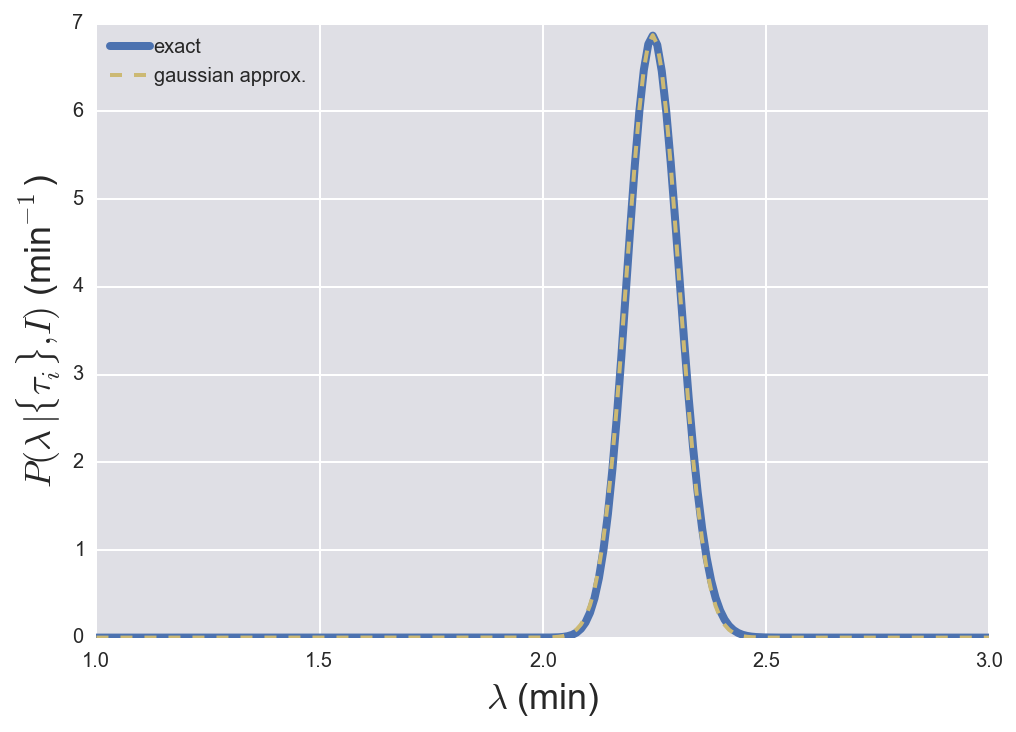

In [151]:
# Lambda values for plotting.
lam = np.linspace(1, 3, 200)

# Use wild type sleep bouts
tau = wt_bouts

def posterior_exp(lam, tau):
    """
    Posterior probability distribution for exponentially
    distributed waiting times tau.
    """
    n = len(tau)
    a = tau.sum()
    log_dist = n * np.log(a) - (n + 1) * np.log(lam) - a / lam \
             - scipy.special.gammaln(n)

    return np.exp(log_dist)


def gaussian_approx(lam, tau):
    """
    Gaussian distribution (could use scipy.stats, but this is fine).
    """
    n = len(tau)
    a = tau.sum()
    sig2 = a**2 / (n+1)**3
    mu = tau.sum() / (len(tau) + 1)
    return 1 / np.sqrt(2 * np.pi * sig2) * np.exp(-(lam - mu)**2 / 2 / sig2)


# Plot the two distributions
plt.plot(lam, posterior_exp(lam, tau), lw=4)
plt.plot(lam, gaussian_approx(lam, tau), '--', color=sns.color_palette()[4])
plt.legend(('exact', 'gaussian approx.'), loc='upper left')
plt.xlabel(r'$\lambda$ (min)')
plt.ylabel(r'$P(\lambda \mid \{\tau_i\},I)$ (min$^{-1}$)')

That's a very good approximation!

**b)** Independent experiments to get likelihood.  Uniform prior.  Algebraic grunge.

**c**) The calculation is straightforward.  For each fish $j$, we compute $\lambda_j$ and its variance $\sigma_j$.  We then compute $\sigma^2$ and $\bar{\lambda}$ from these.  We then have the ingredients for our posterior distribution.

In [159]:
# Compute a and n for each fish
df_rest_bout['a'] = df_rest_bout['rest_bout_lengths'].map(lambda x: x.sum())
df_rest_bout['n'] = df_rest_bout['rest_bout_lengths'].map(lambda x: len(x))

# Compute lambda and sigma_j for each fish
df_rest_bout['lam'] = df_rest_bout['a'] / (df_rest_bout['n'] + 1)
df_rest_bout['sigma2'] = df_rest_bout['a']**2 / (df_rest_bout['n'] + 1)**3
df_rest_bout['lam/sigma2'] = df_rest_bout['lam'] / df_rest_bout['sigma2']

Now we can compute $\bar{\lambda}$ and $\sigma$ for each genotype.  We need to cut out mutants with no rest bouts because we cannot determine a probability distribution for them with no samples.  These two mutant fish would only serve to strengthen the hypothesis that they have shorter rest bouts.

In [169]:
# Get convenient groupby object cutting out ones with no rest bouts
df_gb = df_rest_bout[df_rest_bout['n']>0].groupby('genotype')

# Compute sigma and lambda bar
sigma2 = 1.0 / df_gb['sigma2'].apply(lambda x: (1/x).sum())
lam_bar = sigma2 * df_gb['lam/sigma2'].sum()

Now, we need a function to make a Gaussian distribution, given $\sigma^2$ and $\bar{\lambda}$.

In [172]:
def gaussian_mean_of_mean(mu, lam_bar, sigma2):
    """
    Gaussian distribution for mean of means.
    """
    return np.exp(-(lam_bar - mu)**2 / 2 / sigma2) / np.sqrt(2 * np.pi * sigma2)

And now we can plot!

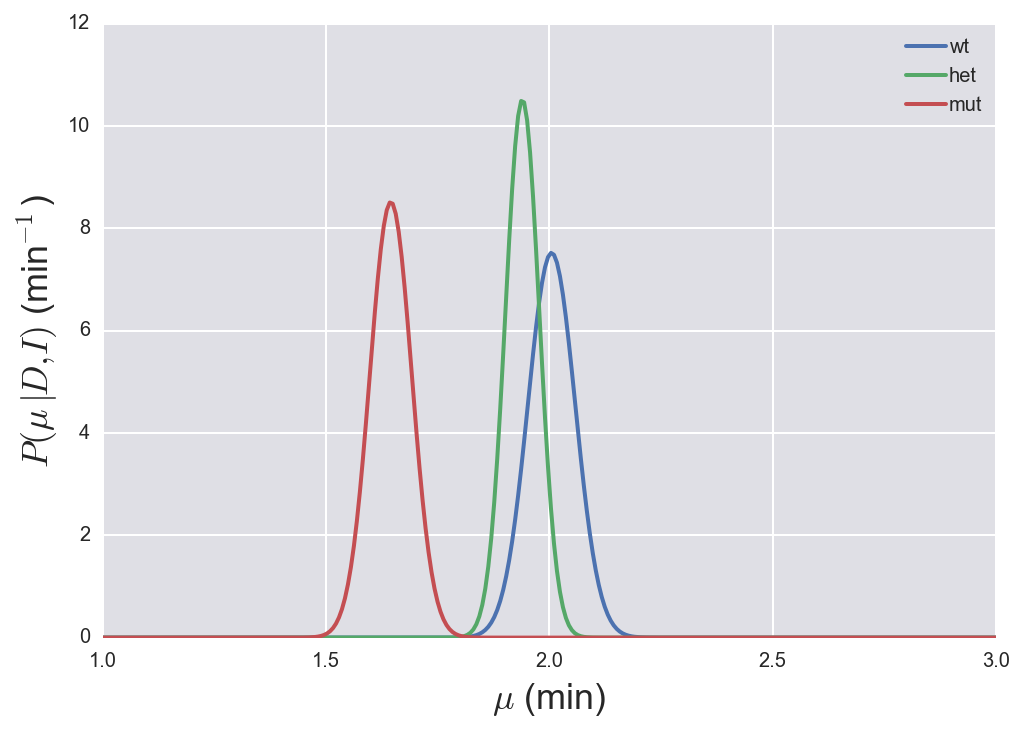

In [176]:
# Set mu values for plot
mu = np.linspace(1, 3, 300)

# Make plots of the three posteriors
gtypes = ['wt', 'het', 'mut']
for gtype in gtypes:
    y = gaussian_mean_of_mean(mu, lam_bar[gtype], sigma2[gtype])
    plt.plot(mu, y)
    
# Labels
plt.legend(('wt', 'het', 'mut'), loc='upper right')
plt.xlabel(r'$\mu$ (min)')
plt.ylabel(r'$P(\mu \mid D, I)$ (min$^{-1}$)')

Computing the errors in the estimates for the mean bout length for each fish enables us to have the confidence to say that the mutant fish have a rest bout length about 20% shorter than wild type.  Interestingly, performing the analysis this way, in a hierarchical model, gives a smaller mean bout length than using the pooled data for each phenotype.  This tells us that the fish are not all identical.  The effect size is still roughly the same, though.

<br />
<br />

### Problem 2.3 (Effects of the prior, 40 pts extra credit)

*This problem will be better understood after lecture on Wednesday, October 7.*

As we have seen and will continue to see in class, it is important to carefully choose the prior distribution.  However, for many parameter estimation problems where there are many data, the contribution of the prior is overwhelmed by the likelihood, so the exact functional form (within some constraints) of the prior is less important.  We will explore this computationally in this problem.

As in lecture and in [Tutorial 2b](http://bebi103.caltech.edu/2015/tutorials/t2b_defining_and_estimating_parameters.html), we will assume that the data all have errors drawn from an independent Gaussian sampling distribution with variance $\sigma^2$.  We do not assume we know what $\sigma$ is.  Our likelihood is

\begin{align}
P(D \mid \mu, \sigma, I) = \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^n
\prod_{x_i\in D} \mathrm{e}^{-(x_i - \mu)^2/2\sigma^2},
\end{align}

where $n = |D|$ is the number of points in the data set.  The posterior distribution is then

\begin{align}
P(\mu, \sigma \mid D,I) \propto P(D \mid \mu, \sigma, I)\,P(\mu, \sigma \mid I),
\end{align}

where the latter probability distribution is our prior.

I will demonstrate how to compute and plot the posterior with example fake data.  Note that it is much easier to compute

\begin{align}
\ln P(\mu, \sigma \mid D,I) = \text{constant} + \ln P(D \mid \mu, \sigma, I)
+ \ln P(\mu, \sigma \mid I)
\end{align}

because of precision issues and other reasons.  We do not really care about normalization, so we can set the constant to whatever we please to make exponentiation of the logarithm easier.  In my example, we take a prior in which $\mu$ and $\sigma$ are independent, $\mu$ is uniform on the interval $[\mu_\mathrm{min},\mu_\mathrm{max}]$ and $\sigma$ has a Jeffreys prior.  I.e.,

\begin{align}
P(\mu,\sigma \mid I) = P(\mu \mid I)\,P(\sigma \mid I) \propto \left\{
\begin{array}{cl}
\sigma^{-1} & \text{for }\mu_\mathrm{min} < \mu < \mu_\mathrm{max},\;\sigma > 0,\\[1em]
0 & \text{otherwise}.
\end{array}
\right.
\end{align}

To start the example calculation, I'll first define some handy functions for computing the posterior probability.

In [52]:
def log_prior(mu, sigma, mu_range):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    if sigma < 0.0 or mu < mu_range[0] or mu > mu_range[1]:
        return -np.inf
    else:
        return -np.log(sigma)


def log_likelihood(data, mu, sigma):
    """
    Log of the unnormalized likelihood for a single mu and sigma 
    for Gaussian distributed data.
    """
    return -((data - mu)**2).sum() / (2 * sigma**2) - n * np.log(sigma)


def log_posterior(log_likelihood_fun, log_prior_fun, data, mu, sigma, 
                  mu_range):
    """
    Compute the log of the posterior, given an array of data, plus
    arrays of mu and sigma.  The functions defining the likelihood
    and prior are given by log_likelihood_fun and log_prior_fun, 
    respectively.
    
    Returns a 2D array of the posterior where entry i,j corresponds to
    mu[j], sigma[i].
    
    There are faster ways to calculate this, but we're doing it this way
    because we will use similar definitions when we do MCMC.
    """
    log_post = np.empty((len(sigma), len(mu)))
    for i, sig in enumerate(sigma):
        for j, m in enumerate(mu):
            log_post[i, j] = log_likelihood_fun(data, m, sig) \
                                + log_prior_fun(m, sig, mu_range)

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

Now that we have these functions in hand, we can cook up some fake data and compute the posterior probability.

In [53]:
# Generate 17 fake data, normally distributed with mean = std = 1.
np.random.seed(42)
real_mean = 1.0
real_std = 1.0
data = np.random.normal(real_mean, real_std, 17)

# Number of data points, for convenience
n = len(data)

# Ranges to sample parameters
mu = np.linspace(0.0, 2.0, 200)
sigma = np.linspace(0.01, 2.0, 200)

# Assume mu uniform on -1.5 < mu < 2.0
mu_range = (-1.5, 2.0)

# Compute the posterior
log_post = log_posterior(log_likelihood, log_prior, data, mu, sigma, mu_range)

Now that we can compute the posterior, we can plot it.  Since it is a function of two variables, we need to make a 3D-like plot.  Contour plots are particularly useful for this.  I like to use filled contours, which we can make using the `plt.contourf()` function.  I'll use the `'Blues'` colormap.

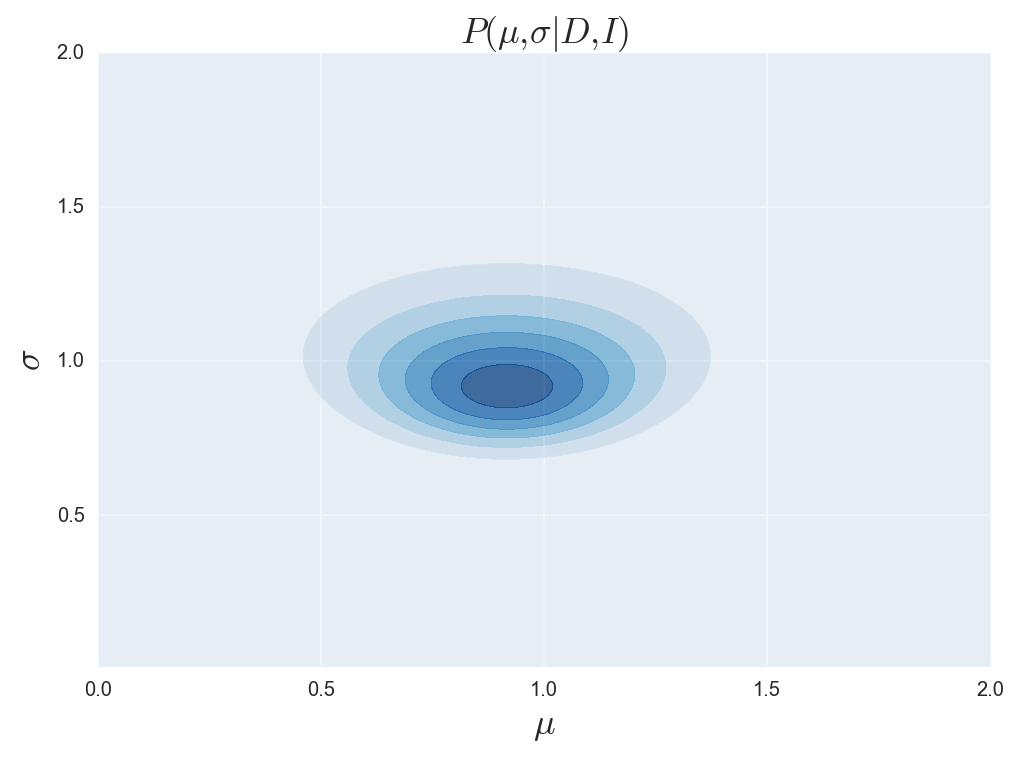

In [54]:
# Use contourf with Blues colormap.
plt.contourf(mu, sigma, np.exp(log_post), cmap=plt.cm.Blues, alpha=0.75)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$P(\mu,\sigma|D,I)$');

Another alternative is to plot $P(\mu,\sigma \mid D,I)$ as a 3D wire plot.  For this, we need to use `Axes3D` from `matplotlib`.

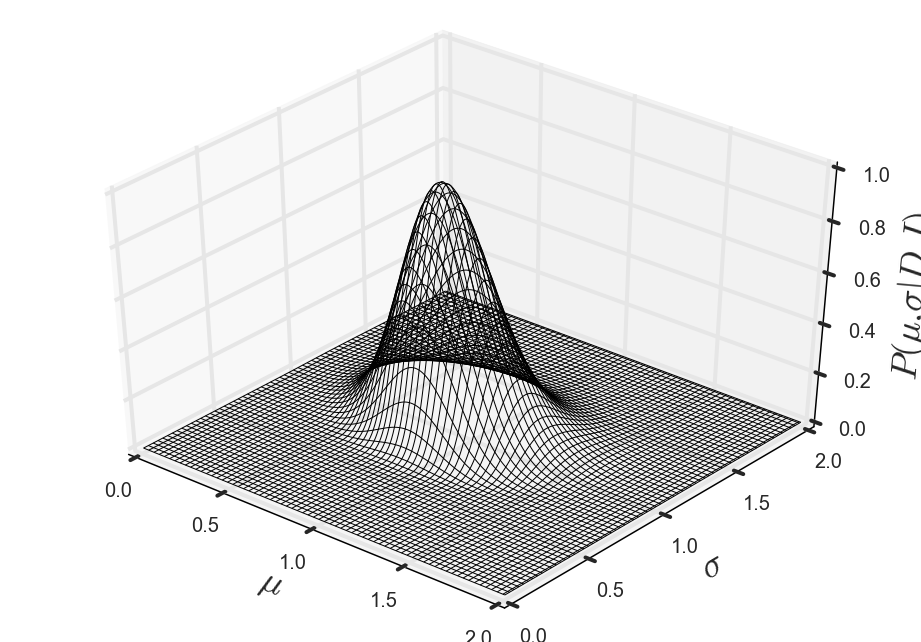

In [55]:
# Make 3D wire plot
with sns.axes_style("white"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mmu, ssigma = np.meshgrid(mu, sigma)
    ax.plot_wireframe(mmu, ssigma, np.exp(log_post), rstride=3, cstride=3, 
                      lw=0.5)
    ax.view_init(40, -50)
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$\sigma$')
    ax.set_zlabel(r'$P(\mu,\sigma|D,I)$')

(The labels being cut off are a problem only in the notebook.  If you save the figure using `plt.savefig()`, it looks fine.)  In lieu of analytically computing the most probable values of $\mu$ and $\sigma$ analytically (which is possible), we will just approximate them by the largest in our sampling.

In [56]:
# Approximate most probable value of mu and sigma
most_prob_inds = np.unravel_index(log_post.argmax(), log_post.shape)
mu_most_prob = mu[most_prob_inds[1]]
sigma_most_prob = sigma[most_prob_inds[0]]

print('most probable mu    = {0:.3f}'.format(mu_most_prob))
print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

most probable mu    = 0.915
most probable sigma = 0.910


We will use data from the Gandhi, et al. data set that we analyzed in [Tutorial 2](http://bebi103.caltech.edu/2015/tutorials.html).  We will take as our data set the total minutes of activity of wild type larvae during the third night of the experiment.  This is the total number of minutes that each fish was active on that night.

**a)** Using the CSV files we made in [Tutorial 2](http://bebi103.caltech.edu/2015/tutorials/t2a_defining_and_estimating_parameters.html), generate an array (either a NumPy array or a `pandas` Series) containing the total number of sleep minutes during the third night of the experiment of each wild type fish.  This array should have 17 entries.

**b)** Compute and plot the posterior probability $P(\mu,\sigma\mid D,I)$.  Assume $\mu$ and $\sigma$ have independent priors.  Assume the prior for $\mu$ is uniform on an appropriate domain and that the prior for $\sigma$ is a Jeffreys prior ($P(\sigma\mid I) \propto \sigma^{-1})$.  Use the rough calculation method above to compute the most probable values of $\mu$ and $\sigma$.

**c)** Do the same as for part (b), except with a uniform prior for $\sigma$.  Does using a Jeffreys prior make much difference?  Whether it does or does not, why do you think this is the case?

**d)** Again assume a Jeffreys prior for $\sigma$.  Assume a Gaussian prior for $\mu$ with mean of 225 minutes and standard deviation of 150 minutes.  What effect does choosing this prior as opposed to a uniform prior have on the posterior probability?

**e)** Now assume a standard deviation of 20 minutes for the prior for $\mu$.  How is the posterior effected?

As you complete this problem, you should note that not all data you are analyzing will have the same sensitivity to prior information.  Researchers often test robustness of their results to choices of prior, and this is often a good idea.

### Problem 2.1 solution

Since we will need to approximate parameters and make plots several time, it is useful to define some functions to do that ahead of time.

In [83]:
def plot_contour(ax, mu, sigma, log_post, y_label=r'$\sigma$',
                 title_str=r'$P(\mu,\sigma|D,I)$'):
    """
    Makes a contour plot of the posterior distribution specified by its
    logarithm, log_post.
    """
    ax.contourf(mu, sigma, np.exp(log_post), cmap=plt.cm.Blues, alpha=0.75)
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(y_label)
    ax.set_title(title_str)
    return ax

def print_most_prob(mu, sigma, log_post):
    """
    Prints the approximate most probable values of mu and sigma to the 
    screen, given the log of the posterior, log_post.
    """
    most_prob_inds = np.unravel_index(log_post.argmax(), log_post.shape)
    mu_most_prob = mu[most_prob_inds[1]]
    sigma_most_prob = sigma[most_prob_inds[0]]
    print('most probable mu    = {0:.3f} minutes'.format(mu_most_prob))
    print('most probable sigma = {0:.3f} minutes'.format(sigma_most_prob))

**a)** We will load in the data from the tutorial.  Computing the total number of sleep minutes is then easily done using methods native to Pandas `DataFrame`s.  we assume a wake threshold close to zero, and a sleep minute is defined as any minute where the number of seconds of activity is below that threshold.

In [84]:
# This is the tidy data set with the one-minute interval sleep data.
df = pd.read_csv('data/130315_1_minute_intervals.csv')

# Indices we want
inds = (~df.light) & (df.day == 2) & (df.activity < 1e-5) & (df.genotype == 'wt')

# Pluck our data and count number of sleeping minutes; store as NumPy array
n_sleep_min = df[inds].groupby('fish')['fish'].count().values

# Take a look
n_sleep_min

array([200, 190, 200, 249, 232, 319, 104,  93, 233, 287,  49, 311, 225,
       243, 113, 133, 179])

**b)** We can directly use the functions given in the problem statement to compute the posterior.  We will plot it in a similar fashion as well.

most probable mu    = 197.487 minutes
most probable sigma = 73.367 minutes


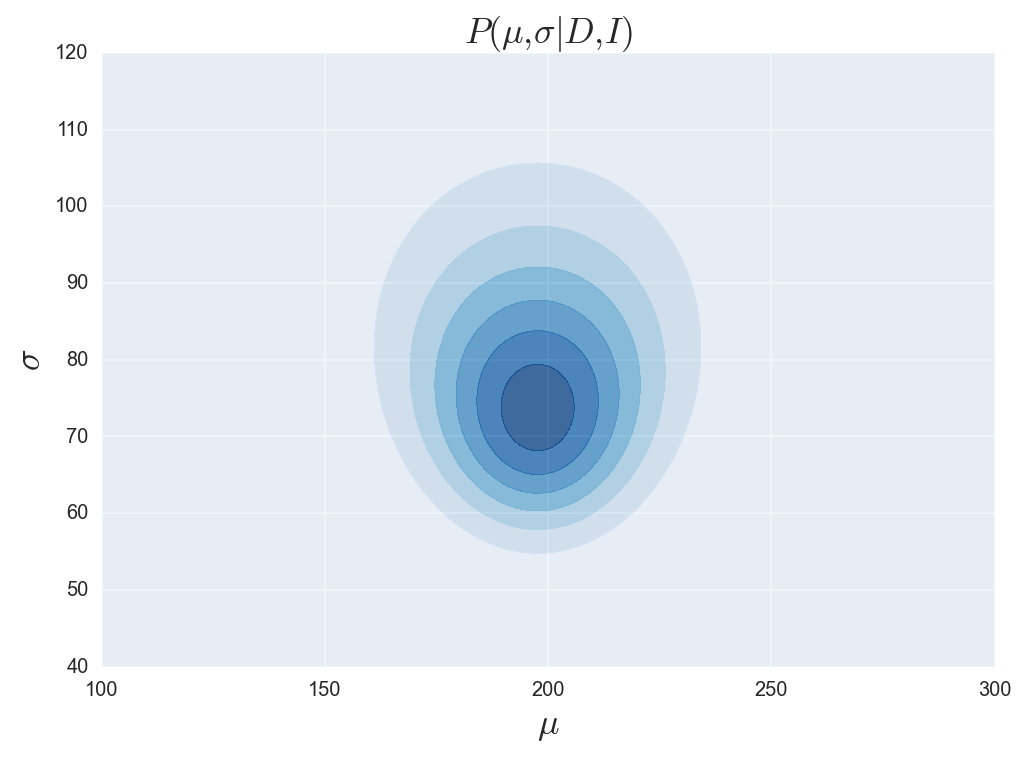

In [85]:
# Ranges to sample parameters
mu = np.linspace(100.0, 300.0, 200)
sigma = np.linspace(40.0, 120.0, 200)

# mu must be positive, and the maximal amount of inactivity is 600 minutes,
# the total duration of the night.
mu_range = (0.0, 600.0)

# Compute the posterior
log_post_partb = log_posterior(log_likelihood, log_prior, n_sleep_min, mu, 
                               sigma, mu_range)

# Plot the results and print to screen
fig, ax = plt.subplots()
ax = plot_contour(ax, mu, sigma, log_post_partb)
print_most_prob(mu, sigma, log_post_partb)

So, the most probable mean number of minutes slept on the third night is $\mu^* \approx 200$ minutes, or about three hours.  The most probable standard deviation is $\sigma^* \approx 74$ minutes.  Note that this standard deviation is **not** the standard error of the mean.

**c)** We first write a function to give a flat prior for $\mu$.  In the prior is a constant, it contributes an additive constant to the logarithm of the posterior.  Since we do not deal with normalization, we can arbitrarily set the logarithm of this constant to zero.  We can do this for both the uniform prior for $\mu$ and for $\sigma$.

In [86]:
def log_prior_flat(mu, sigma, mu_range):
    """
    Log of flat prior.
    """
    return 0.0

After defining the log of the prior, we can compute the posterior as before.

most probable mu    = 197.487 minutes
most probable sigma = 75.377 minutes


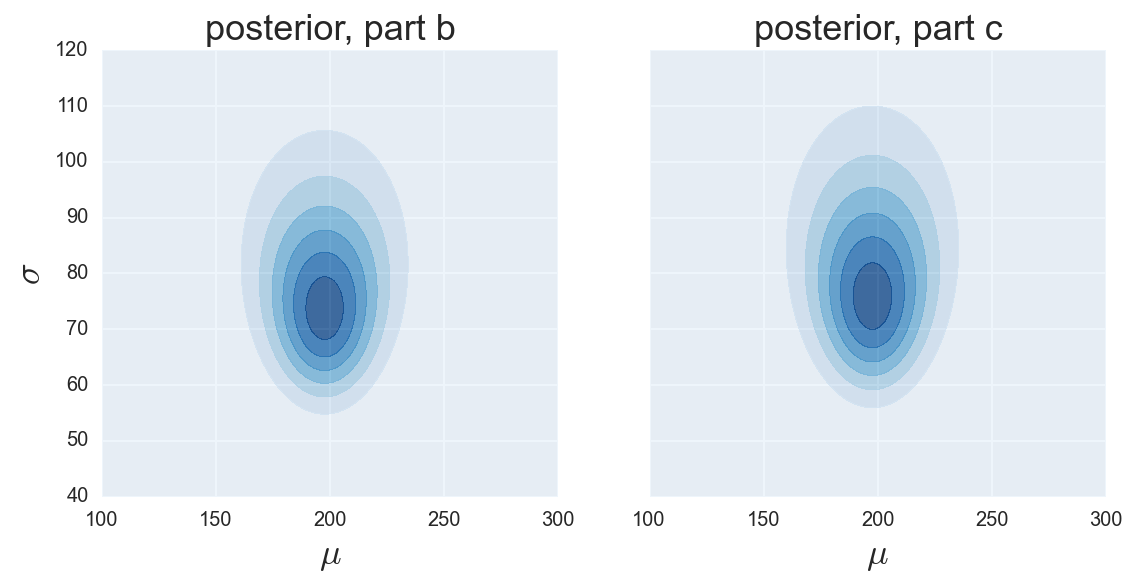

In [87]:
# Compute the posterior, this time with a flat prior
log_post = log_posterior(log_likelihood, log_prior_flat, n_sleep_min, mu, 
                         sigma, mu_range)

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post_partb, 
                     title_str='posterior, part b')
ax[1] = plot_contour(ax[1], mu, sigma, log_post, y_label='',
                     title_str='posterior, part c')
print_most_prob(mu, sigma, log_post)

The most probable value for $\mu$ did not change.  We do see a shift in the most probable value for $\sigma$, though it only changed by about 2%.  The posterior distribution is very similar, with only a small shift in $\sigma$.  So, it does not seem like the Jeffreys prior matters much for the calculation of the posterior.  This can be seen by the relative contributions of each term in the logarithm of the posterior.

\begin{align}
\ln P(\mu,\sigma~|~D,I) = \text{constant} - (n+1) \ln \sigma - \sum_{i\in D}\frac{(x_i - \mu)^2}{2\sigma^2}.
\end{align}

The Jeffreys prior contributed $\log \sigma$ to the log of the posterior.  This is the "$+1$" in the $(n+1)\ln \sigma$ term.  If $n$ is large, $n+1 \approx n$, so the Jeffreys prior does not make much difference.  This is not generally true for all likelihood functions, but is often the case when the likelihood is Gaussian.

**d)** With a Gaussian prior for $\mu$, the prior is now

\begin{align}
P(\mu,\sigma~|~D,I) \propto \frac{1}{\sigma_\mu}\exp\left[-\frac{(\mu - \mu_\mathrm{prior})^2}{2\sigma_\mu}\right].
\end{align}

This gives a log prior of

\begin{align}
ln P(\mu,\sigma~|~D,I) = \text{constant} - \ln \sigma - \ln \sigma_\mu - \frac{(\mu-\mu_\mathrm{prior})^2}{2\sigma_\mu}.
\end{align}

We use this function as our log prior and proceed as before.  For part (d), we use $\mu_\mathrm{prior} = 225$ minutes and $\sigma_\mu = 150$ minutes.

most probable mu    = 216.583 minutes
most probable sigma = 75.779 minutes


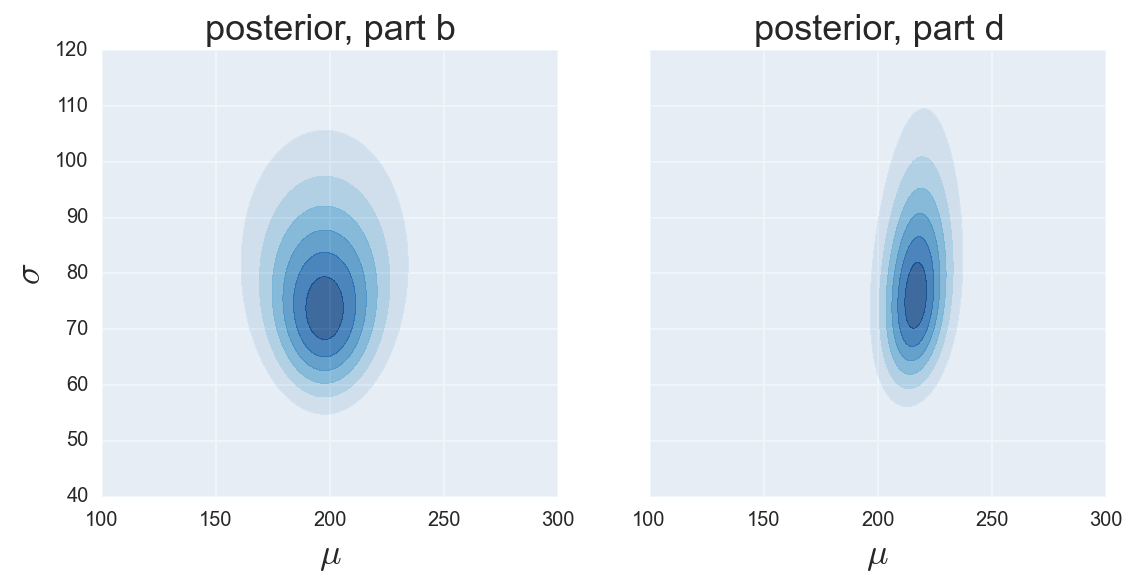

In [90]:
# We have to redine our posterior function to include extra prior parameters
def log_posterior_gaussian_prior(log_likelihood_fun, log_prior_fun, data, mu,
                                 sigma, mu_range, mu_prior, sigma_mu):
    """
    Compute the log of the posterior, given an array of data, plus
    arrays of mu and sigma.  The functions defining the likelihood
    and prior are given by log_likelihood_fun and log_prior_fun, 
    respectively.
    
    Returns a 2D array of the posterior where entry i,j corresponds to
    mu[j], sigma[i].
    
    There are faster ways to calculate this, but we're doing it this way
    because we will use similar definitions when we do MCMC.
    """
    log_post = np.empty((len(sigma), len(mu)))
    for i, sig in enumerate(sigma):
        for j, m in enumerate(mu):
            log_post[i, j] = log_likelihood_fun(data, m, sig) \
               + log_prior_fun(m, sig, mu_range, mu_prior, sigma_mu)

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

# Define the Gaussian log prior
def log_prior_gaussian(mu, sigma, mu_range, mu_prior, sigma_mu):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    if sigma < 0.0 or mu < mu_range[0] or mu > mu_range[1]:
        return -np.inf
    else:
        return -np.log(sigma) - np.log(sigma_mu) \
                    - (mu - mu_prior)**2 / 2.0 / sigma_mu

# Define values of mu_prior and sigma_mu
mu_prior = 225.0
sigma_mu = 150.0
        
# Compute the posterior
log_post = log_posterior_gaussian_prior(
          log_likelihood, log_prior_gaussian, n_sleep_min, mu, sigma, 
          mu_range, mu_prior, sigma_mu)

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post_partb, 
                     title_str='posterior, part b')
ax[1] = plot_contour(ax[1], mu, sigma, log_post, y_label='',
                     title_str='posterior, part d')
print_most_prob(mu, sigma, log_post)

From the plot of the posterior, we see that it is skewed to the right.  The prior information has influenced the result.  Because $\sigma_\mu$ is not too small, the data still pulled the most probable $\mu$ leftward from 225 minutes to about 215 minutes.

**e)** We do precisely the same analysis as in part (d).

most probable mu    = 223.618 minutes
most probable sigma = 77.789 minutes


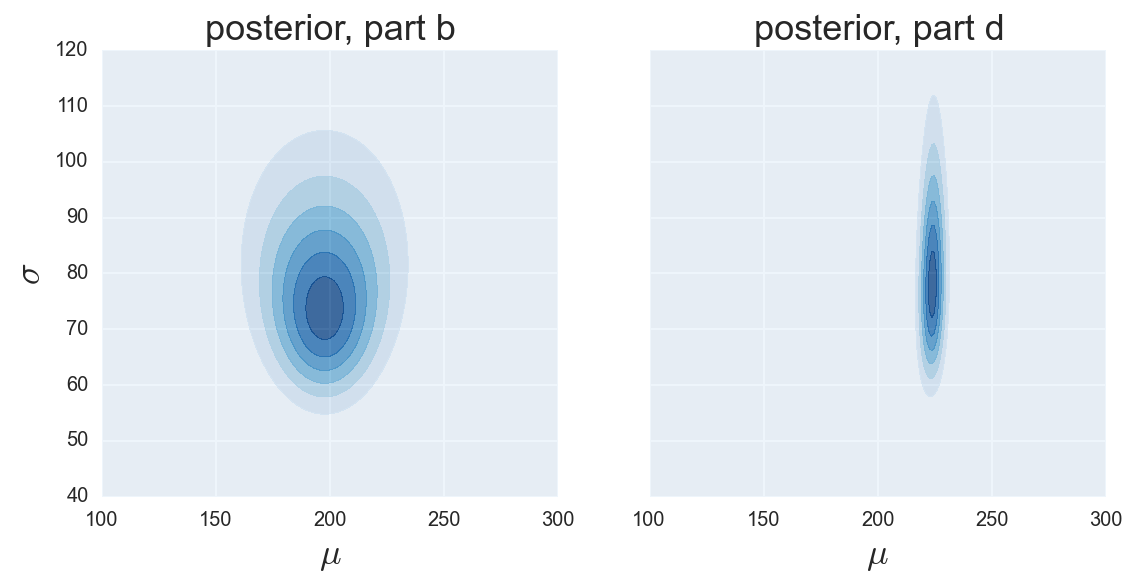

In [91]:
# Define values of mu_prior and sigma_mu
mu_prior = 225.0
sigma_mu = 15.0
        
# Compute the posterior
log_post = log_posterior_gaussian_prior(
          log_likelihood, log_prior_gaussian, n_sleep_min, mu, sigma, 
          mu_range, mu_prior, sigma_mu)

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post_partb, 
                     title_str='posterior, part b')
ax[1] = plot_contour(ax[1], mu, sigma, log_post, y_label='',
                     title_str='posterior, part d')
print_most_prob(mu, sigma, log_post)

Now the effect is much stronger because we were more certain with the prior, which is a bit at odds with the measured data.